In [1]:
# Import preliminary packages used for data import and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools
from arch import arch_model
from sklearn.metrics import mean_absolute_error

# Import data, set index and convert to datetime
spy_raw_data = pd.read_csv('SPYMay2015-May2020.csv')
spy_raw_data.Date = pd.to_datetime(spy_raw_data.Date)
spy_raw_data = spy_raw_data.set_index('Date')

In [2]:
# Realized vol windows
one_day = 1
five_day = 5
ten_day = 10
one_month = 21
three_month = 63
one_year = 252

# Annualize realized vol windows
one_ann = one_year
five_ann = one_year/five_day
ten_ann = one_year/ten_day
one_month_ann = one_year/one_month
three_month_ann = one_year/three_month

# Perform column-wise manipulations, such as % diff, log diff
spy_raw_data['high_low'] = spy_raw_data['High']-spy_raw_data['Low']
spy_raw_data['close_log'] = np.log(spy_raw_data['Close']).diff()
spy_raw_data['adj_close_log'] = np.log(spy_raw_data['Adj Close']).diff()
spy_raw_data['open_high_log'] = np.log(spy_raw_data['High'])-np.log(spy_raw_data['Low'])
spy_raw_data['pct_change'] = (spy_raw_data['Adj Close'] - spy_raw_data['Adj Close'].shift(1))/spy_raw_data['Adj Close']

# Calculating demeand variance and then vol for each vol window
spy_raw_data['adj_close_1vol'] = np.sqrt(252*np.pi/2)*np.sqrt((spy_raw_data['adj_close_log']**2))
spy_raw_data['high_low_vol'] = np.sqrt(252*np.pi/2)*np.sqrt((spy_raw_data['open_high_log']**2))
spy_raw_data['adj_close_5var'] = spy_raw_data['adj_close_log'].rolling(five_day).var()*five_ann
spy_raw_data['adj_close_5vol'] = np.sqrt(spy_raw_data['adj_close_5var'])
spy_raw_data['adj_close_10var'] = spy_raw_data['adj_close_log'].rolling(ten_day).var()*ten_ann
spy_raw_data['adj_close_10vol'] = np.sqrt(spy_raw_data['adj_close_10var'])
spy_raw_data['adj_close_21var'] = spy_raw_data['adj_close_log'].rolling(one_month).var()*one_month_ann
spy_raw_data['adj_close_21vol'] = np.sqrt(spy_raw_data['adj_close_21var'])
spy_raw_data['adj_close_63var'] = spy_raw_data['adj_close_log'].rolling(three_month).var()*three_month_ann
spy_raw_data['adj_close_63vol'] = np.sqrt(spy_raw_data['adj_close_63var'])
spy_raw_data['adj_close_252var'] = spy_raw_data['adj_close_log'].rolling(one_year).var()
spy_raw_data['adj_close_252vol'] = np.sqrt(spy_raw_data['adj_close_252var'])

# Gets rid of NaN values from lag calculations above
spy_raw_data = spy_raw_data.replace(np.nan,0,regex=True)

# Displays mean and standard deviation of 1d realized volatility, prediction variable of interest
spy_mean_vol = np.mean(spy_raw_data['adj_close_1vol'])
spy_std_vol = np.std(spy_raw_data['adj_close_1vol'])
print("The mean realized 1 day volatility for the dataset is: %.4f"%spy_mean_vol)
print("The standard deviation of realized 1 day volatility for the dataset is: %.4f"%spy_std_vol)

The mean realized 1 day volatility for the dataset is: 0.1361
The standard deviation of realized 1 day volatility for the dataset is: 0.1905


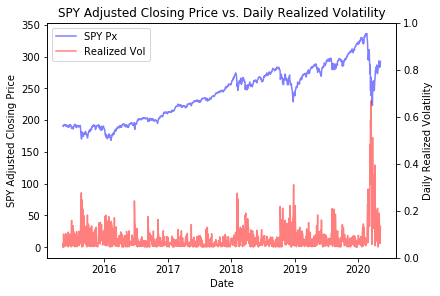

In [3]:
# Plot SPY Adj Closing Price vs. Realized Volatility daily plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
fig,ax = plt.subplots(constrained_layout=True)
ax.plot(spy_raw_data.index, spy_raw_data['Adj Close'], color = 'blue', alpha=0.5, label='SPY Px')
ax.set_xlabel('Date')
ax.set_ylabel('SPY Adjusted Closing Price')
ax.set_title('SPY Adjusted Closing Price vs. Daily Realized Volatility')
ax2 = ax.twinx()
ax.plot(spy_raw_data.index, spy_raw_data['adj_close_1vol']*100, color='red', alpha=0.5, label='Realized Vol')
ax2.set_ylabel('Daily Realized Volatility')
ax.legend()
plt.show()

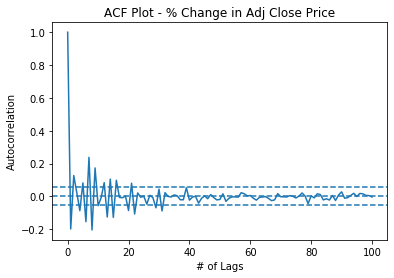

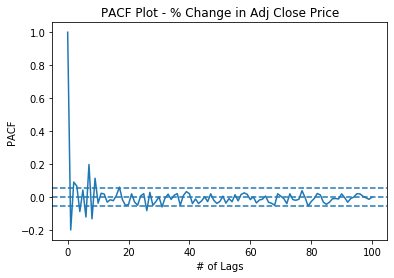

In [4]:
# ACF Plot of log returns
acf_result_log_close = stattools.acf(spy_raw_data['adj_close_log'],nlags=100,fft=False)
plt.title('ACF Plot - % Change in Adj Close Price')
plt.xlabel('# of Lags')
plt.ylabel('Autocorrelation')
plt.plot(acf_result_log_close)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(spy_raw_data['adj_close_log'])),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(spy_raw_data['adj_close_log'])),linestyle='--')
plt.show()

# PACF plot of log returns
pacf_result_log_close = stattools.pacf(spy_raw_data['adj_close_log'],nlags=100)
plt.title('PACF Plot - % Change in Adj Close Price')
plt.xlabel('# of Lags')
plt.ylabel('PACF')
plt.plot(pacf_result_log_close)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(spy_raw_data['adj_close_log'])),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(spy_raw_data['adj_close_log'])),linestyle='--')
plt.show()

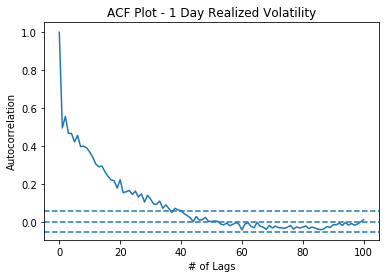

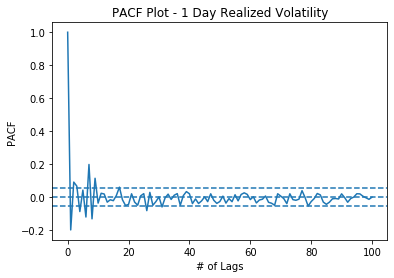

In [5]:
# ACF plot of 1 day realized volatility
acf_result_1vol = stattools.acf(spy_raw_data['adj_close_1vol'],nlags=100,fft=False)
plt.title('ACF Plot - 1 Day Realized Volatility')
plt.xlabel('# of Lags')
plt.ylabel('Autocorrelation')
plt.plot(acf_result_1vol)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(spy_raw_data['adj_close_1vol'])),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(spy_raw_data['adj_close_1vol'])),linestyle='--')
plt.show()

# PACF plot of 1 day realized volatility
pacf_result_1vol = stattools.pacf(spy_raw_data['adj_close_log'],nlags=100)
plt.title('PACF Plot - 1 Day Realized Volatility')
plt.xlabel('# of Lags')
plt.ylabel('PACF')
plt.plot(pacf_result_1vol)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(spy_raw_data['adj_close_1vol'])),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(spy_raw_data['adj_close_1vol'])),linestyle='--')
plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -821.2886169237993
Iteration:      2,   Func. Count:     21,   Neg. LLF: -932.4297377912826
Iteration:      3,   Func. Count:     29,   Neg. LLF: -933.0129527460141
Iteration:      4,   Func. Count:     36,   Neg. LLF: -937.602020252797
Iteration:      5,   Func. Count:     43,   Neg. LLF: -937.7911516610251
Iteration:      6,   Func. Count:     50,   Neg. LLF: -938.0560765603079
Iteration:      7,   Func. Count:     57,   Neg. LLF: -938.1355487296945
Iteration:      8,   Func. Count:     65,   Neg. LLF: -938.1793253713303
Iteration:      9,   Func. Count:     71,   Neg. LLF: -938.2278949958641
Iteration:     10,   Func. Count:     79,   Neg. LLF: -938.2300778304665
Iteration:     11,   Func. Count:     85,   Neg. LLF: -938.2349265515986
Iteration:     12,   Func. Count:     91,   Neg. LLF: -938.2349280077377
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -938.2349280076913
            Ite

/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

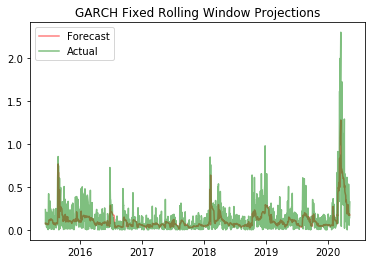

Mean absolute error of forecasted volatility for fixed rolling window GARCH model: 0.08451423218715327
Mean absolute error of forecasted volatility for null model: 0.12014163249653342


In [6]:
##############################
### GARCH MODELING PORTION ###
##############################

# GARCH FIXED ROLLING WINDOW (21d)
start_loc = 0
window_size = 21
end_loc = window_size
steps = 30
forecasts = {}
model = arch_model(spy_raw_data['adj_close_1vol'],vol='GARCH',p=1,q=1, rescale=False)
model_fit = model.fit()
for i in range(len(spy_raw_data)-window_size):
    model_result = model.fit(first_obs=i+start_loc,last_obs=i+end_loc, disp='off')
    temp_result = model_result.forecast(horizon=1).variance
    fcast = temp_result.iloc[i+end_loc]
    forecasts[fcast.name] = fcast
forecast_var = pd.DataFrame(forecasts).T
forecast_vol = np.sqrt(forecast_var)
plt.plot(forecast_vol,color='red',label='Forecast',alpha=0.5)
plt.plot(spy_raw_data['adj_close_1vol'][window_size:],color='green',label='Actual',alpha=0.5)
plt.legend()
plt.title("GARCH Fixed Rolling Window Projections")
plt.plot()
plt.show()

arch_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][window_size:].values, forecast_vol.values)
print("Mean absolute error of forecasted volatility for fixed rolling window GARCH model: {}".format(arch_mae))

null_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][window_size:].values,
                                spy_raw_data['adj_close_1vol'][window_size-1:-1].values)
print("Mean absolute error of forecasted volatility for null model: {}".format(null_mae))

Iteration:      1,   Func. Count:      7,   Neg. LLF: -820.7915403673437
Iteration:      2,   Func. Count:     23,   Neg. LLF: -893.5022723774873
Iteration:      3,   Func. Count:     35,   Neg. LLF: -893.89091249903
Iteration:      4,   Func. Count:     44,   Neg. LLF: -926.2526215659452
Iteration:      5,   Func. Count:     52,   Neg. LLF: -931.2358039624577
Iteration:      6,   Func. Count:     61,   Neg. LLF: -938.2882891057077
Iteration:      7,   Func. Count:     69,   Neg. LLF: -939.4786974296289
Iteration:      8,   Func. Count:     78,   Neg. LLF: -939.8392509046078
Iteration:      9,   Func. Count:     86,   Neg. LLF: -939.9650252082449
Iteration:     10,   Func. Count:     94,   Neg. LLF: -940.274928744393
Iteration:     11,   Func. Count:    101,   Neg. LLF: -940.4171434919681
Iteration:     12,   Func. Count:    108,   Neg. LLF: -940.4377023591696
Iteration:     13,   Func. Count:    115,   Neg. LLF: -940.4394389192089
Iteration:     14,   Func. Count:    122,   Neg. LLF: 

/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code mean

/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


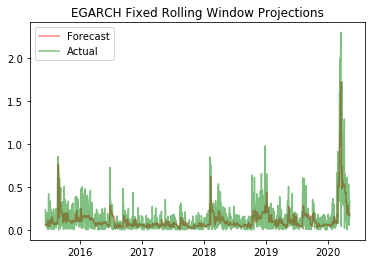

Mean absolute error of forecasted volatility for fixed rolling window GJR GARCH model: 0.08666413497530161
Mean absolute error of forecasted volatility: 0.12014163249653342


In [7]:
# GJR GARCH FIXED ROLLING WINDOW (21d)
start_loc = 0
window_size = 21
end_loc = window_size
gjr_forecasts = {}
gjr_model = arch_model(spy_raw_data['adj_close_1vol'],vol='GARCH',p=1,q=1,o=1, rescale=False)
gjr_model_fit = gjr_model.fit()
for i in range(len(spy_raw_data)-window_size):
    gjr_model_result = gjr_model.fit(first_obs=i+start_loc,last_obs=i+end_loc, disp='off')
    gjr_temp_result = gjr_model_result.forecast(horizon=1).variance
    gjr_fcast = gjr_temp_result.iloc[i+end_loc]
    gjr_forecasts[gjr_fcast.name] = gjr_fcast
gjr_forecast_var = pd.DataFrame(gjr_forecasts).T
gjr_forecast_vol = np.sqrt(gjr_forecast_var)
plt.plot(gjr_forecast_vol,color='red',label='Forecast',alpha=0.5)
plt.plot(spy_raw_data['adj_close_1vol'][window_size:],color='green',label='Actual',alpha=0.5)
plt.legend()
plt.title("EGARCH Fixed Rolling Window Projections")
plt.plot()
plt.show()

gjr_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][window_size:].values, gjr_forecast_vol.values)
print("Mean absolute error of forecasted volatility for fixed rolling window GJR GARCH model: {}".format(gjr_mae))

null_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][window_size:].values,
                                spy_raw_data['adj_close_1vol'][window_size-1:-1].values)
print("Mean absolute error of forecasted volatility: {}".format(null_mae))

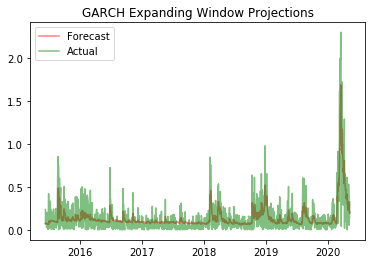

Mean absolute error of forecasted volatility: 0.08161670916931622
Mean absolute error of forecasted volatility: 0.12014163249653342


In [8]:
# GARCH EXPANDING WINDOW
start_loc_exp = 0
end_loc_exp = 21
garch_exp_forecasts = {}
for i in range(len(spy_raw_data)-21):
    garch_exp_result = model.fit(first_obs = start_loc_exp, last_obs = i + end_loc_exp, disp='off')
    temp_garch_exp_result = garch_exp_result.forecast(horizon=1).variance
    fcast_garch_exp = temp_garch_exp_result.iloc[i+end_loc_exp]
    garch_exp_forecasts[fcast_garch_exp.name] = fcast_garch_exp
forecast_garch_exp_var = pd.DataFrame(garch_exp_forecasts).T
forecast_garch_exp_vol = np.sqrt(forecast_garch_exp_var)
plt.plot(forecast_garch_exp_vol,color='red',label='Forecast',alpha=0.5)
plt.plot(spy_raw_data['adj_close_1vol'][21:],color='green',label='Actual',alpha=0.5)
plt.legend()
plt.title("GARCH Expanding Window Projections")
plt.plot()
plt.show()

garch_exp_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][21:len(forecast_garch_exp_vol)+21].values, 
                                    forecast_garch_exp_vol.values)
print("Mean absolute error of forecasted volatility: {}".format(garch_exp_mae))
null_exp_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][21:len(forecast_garch_exp_vol)+21].values,
                                    spy_raw_data['adj_close_1vol'][20:len(forecast_garch_exp_vol)+20].values)
print("Mean absolute error of forecasted volatility: {}".format(null_exp_mae))

/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


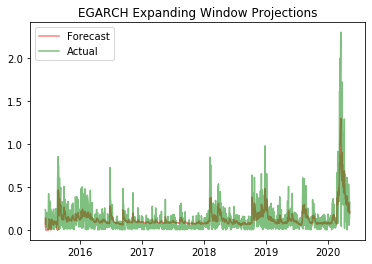

Mean absolute error of forecasted volatility: 0.07981916554958202
Mean absolute error of forecasted volatility: 0.12014163249653342


In [9]:
# EGARCH EXPANDING WINDOW 
egarch_model = arch_model(spy_raw_data['adj_close_1vol'], p=1, q=1, o=1, vol='EGARCH', rescale=False)
start_loc_exp = 0
end_loc_exp = 21
egarch_exp_forecasts = {}
for i in range(len(spy_raw_data)-21):
    egarch_exp_result = egarch_model.fit(first_obs = start_loc_exp, last_obs = i + end_loc_exp, disp = 'off')
    temp_egarch_exp_result = egarch_exp_result.forecast(horizon=1).variance
    fcast_egarch_exp = temp_egarch_exp_result.iloc[i+end_loc_exp]
    egarch_exp_forecasts[fcast_egarch_exp.name] = fcast_egarch_exp
forecast_egarch_exp_var = pd.DataFrame(egarch_exp_forecasts).T
forecast_egarch_exp_vol = np.sqrt(forecast_egarch_exp_var)
plt.plot(forecast_egarch_exp_vol,color='red',label='Forecast',alpha=0.5)
plt.plot(spy_raw_data['adj_close_1vol'][21:],color='green',label='Actual',alpha=0.5)
plt.legend()
plt.title("EGARCH Expanding Window Projections")
plt.plot()
plt.show()

egarch_exp_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][21:len(forecast_egarch_exp_vol)+21].values, 
                                    forecast_egarch_exp_vol.values)
print("Mean absolute error of forecasted volatility: {}".format(egarch_exp_mae))
null_exp_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][21:len(forecast_egarch_exp_vol)+21].values,
                                    spy_raw_data['adj_close_1vol'][20:len(forecast_egarch_exp_vol)+20].values)
print("Mean absolute error of forecasted volatility: {}".format(null_exp_mae))   

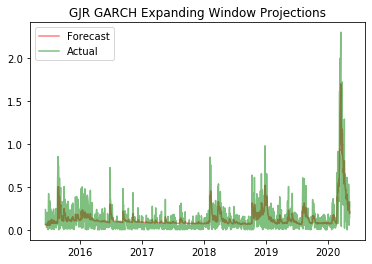

Mean absolute error of forecasted volatility: 0.08016636447312712
Mean absolute error of forecasted volatility: 0.12014163249653342


In [10]:
# GJR GARCH EXPANDING WINDOW
gjrgarch_model = arch_model(spy_raw_data['adj_close_1vol'], p=1, q=1, o=1, vol='GARCH', rescale=False)
start_loc_exp = 0
end_loc_exp = 21
gjrgarch_exp_forecasts = {}
for i in range(len(spy_raw_data)-21):
    gjrgarch_exp_result = gjrgarch_model.fit(first_obs = start_loc_exp, last_obs = i + end_loc_exp, disp = 'off')
    temp_gjrgarch_exp_result = gjrgarch_exp_result.forecast(horizon=1).variance
    fcast_gjrgarch_exp = temp_gjrgarch_exp_result.iloc[i+end_loc_exp]
    gjrgarch_exp_forecasts[fcast_gjrgarch_exp.name] = fcast_gjrgarch_exp
forecast_gjrgarch_exp_var = pd.DataFrame(gjrgarch_exp_forecasts).T
forecast_gjrgarch_exp_vol = np.sqrt(forecast_gjrgarch_exp_var)
plt.plot(forecast_gjrgarch_exp_vol,color='red',label='Forecast',alpha=0.5)
plt.plot(spy_raw_data['adj_close_1vol'][21:],color='green',label='Actual',alpha=0.5)
plt.legend()
plt.title("GJR GARCH Expanding Window Projections")
plt.plot()
plt.show()

gjrgarch_exp_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][21:len(forecast_gjrgarch_exp_vol)+21].values, 
                                    forecast_gjrgarch_exp_vol.values)
print("Mean absolute error of forecasted volatility: {}".format(gjrgarch_exp_mae))
null_exp_mae = mean_absolute_error(spy_raw_data['adj_close_1vol'][21:len(forecast_gjrgarch_exp_vol)+21].values,
                                    spy_raw_data['adj_close_1vol'][20:len(forecast_gjrgarch_exp_vol)+20].values)
print("Mean absolute error of forecasted volatility: {}".format(null_exp_mae))    

In [11]:
##################################
### NON-GARCH MODELING PORTION ###
##################################

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Change max columns displayed to verify accuracy of transformed, lagged datasets implemented below
pd.set_option("max_columns",50)

# Function to help reframe time series data into supervised, regression problem suitable for 
# machine learning problems and neural nets
def series_to_supervised(data, n_in=1,n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments: 
        data: Sequence of observations as a list or NumPy array
        n_in: Number of lag observations as input(X)
        n_out: Number of observations as output (y)
        dropnan: Boolean whether or not to drop rows with NaN values
    Returns: 
        Pandas DataFrame of series framed for supervised learnings
    (Code and docstring from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else: 
            names += [('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
        agg = pd.concat(cols,axis=1)
        agg.columns = names
        if dropnan: 
            agg.dropna(inplace=True)
        return agg

Using TensorFlow backend.


W0629 20:30:28.810241 4651558336 deprecation.py:506] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(629, 1, 2) (629,) (629, 1, 2) (629,)


W0629 20:30:29.590090 4651558336 module_wrapper.py:139] From /opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 629 samples, validate on 629 samples
Epoch 1/750
 - 0s - loss: 0.0950 - val_loss: 0.1414
Epoch 2/750
 - 0s - loss: 0.0813 - val_loss: 0.1295
Epoch 3/750
 - 0s - loss: 0.0779 - val_loss: 0.1257
Epoch 4/750
 - 0s - loss: 0.0771 - val_loss: 0.1248
Epoch 5/750
 - 0s - loss: 0.0767 - val_loss: 0.1249
Epoch 6/750
 - 0s - loss: 0.0763 - val_loss: 0.1255
Epoch 7/750
 - 0s - loss: 0.0762 - val_loss: 0.1260
Epoch 8/750
 - 0s - loss: 0.0763 - val_loss: 0.1260
Epoch 9/750
 - 0s - loss: 0.0763 - val_loss: 0.1257
Epoch 10/750
 - 0s - loss: 0.0763 - val_loss: 0.1254
Epoch 11/750
 - 0s - loss: 0.0762 - val_loss: 0.1250
Epoch 12/750
 - 0s - loss: 0.0762 - val_loss: 0.1247
Epoch 13/750
 - 0s - loss: 0.0761 - val_loss: 0.1244
Epoch 14/750
 - 0s - loss: 0.0760 - val_loss: 0.1241
Epoch 15/750
 - 0s - loss: 0.0759 - val_loss: 0.1238
Epoch 16/750
 - 0s - loss: 0.0759 - val_loss: 0.1237
Epoch 17/750
 - 0s - loss: 0.0758 - val_loss: 0.1236
Epoch 18/750
 - 0s - loss: 0.0758 - val_loss: 0.1235
Epoch 19/

Epoch 154/750
 - 0s - loss: 0.0748 - val_loss: 0.1195
Epoch 155/750
 - 0s - loss: 0.0748 - val_loss: 0.1195
Epoch 156/750
 - 0s - loss: 0.0748 - val_loss: 0.1195
Epoch 157/750
 - 0s - loss: 0.0748 - val_loss: 0.1195
Epoch 158/750
 - 0s - loss: 0.0748 - val_loss: 0.1194
Epoch 159/750
 - 0s - loss: 0.0748 - val_loss: 0.1193
Epoch 160/750
 - 0s - loss: 0.0748 - val_loss: 0.1194
Epoch 161/750
 - 0s - loss: 0.0748 - val_loss: 0.1193
Epoch 162/750
 - 0s - loss: 0.0748 - val_loss: 0.1193
Epoch 163/750
 - 0s - loss: 0.0748 - val_loss: 0.1192
Epoch 164/750
 - 0s - loss: 0.0748 - val_loss: 0.1192
Epoch 165/750
 - 0s - loss: 0.0748 - val_loss: 0.1192
Epoch 166/750
 - 0s - loss: 0.0748 - val_loss: 0.1191
Epoch 167/750
 - 0s - loss: 0.0748 - val_loss: 0.1191
Epoch 168/750
 - 0s - loss: 0.0747 - val_loss: 0.1191
Epoch 169/750
 - 0s - loss: 0.0748 - val_loss: 0.1190
Epoch 170/750
 - 0s - loss: 0.0748 - val_loss: 0.1190
Epoch 171/750
 - 0s - loss: 0.0747 - val_loss: 0.1190
Epoch 172/750
 - 0s - loss: 

Epoch 306/750
 - 0s - loss: 0.0734 - val_loss: 0.1129
Epoch 307/750
 - 0s - loss: 0.0735 - val_loss: 0.1129
Epoch 308/750
 - 0s - loss: 0.0735 - val_loss: 0.1128
Epoch 309/750
 - 0s - loss: 0.0734 - val_loss: 0.1128
Epoch 310/750
 - 0s - loss: 0.0734 - val_loss: 0.1127
Epoch 311/750
 - 0s - loss: 0.0734 - val_loss: 0.1127
Epoch 312/750
 - 0s - loss: 0.0734 - val_loss: 0.1127
Epoch 313/750
 - 0s - loss: 0.0734 - val_loss: 0.1126
Epoch 314/750
 - 0s - loss: 0.0734 - val_loss: 0.1125
Epoch 315/750
 - 0s - loss: 0.0733 - val_loss: 0.1125
Epoch 316/750
 - 0s - loss: 0.0733 - val_loss: 0.1124
Epoch 317/750
 - 0s - loss: 0.0733 - val_loss: 0.1124
Epoch 318/750
 - 0s - loss: 0.0733 - val_loss: 0.1122
Epoch 319/750
 - 0s - loss: 0.0732 - val_loss: 0.1124
Epoch 320/750
 - 0s - loss: 0.0733 - val_loss: 0.1122
Epoch 321/750
 - 0s - loss: 0.0732 - val_loss: 0.1122
Epoch 322/750
 - 0s - loss: 0.0733 - val_loss: 0.1121
Epoch 323/750
 - 0s - loss: 0.0732 - val_loss: 0.1123
Epoch 324/750
 - 0s - loss: 

Epoch 458/750
 - 0s - loss: 0.0725 - val_loss: 0.1107
Epoch 459/750
 - 0s - loss: 0.0725 - val_loss: 0.1107
Epoch 460/750
 - 0s - loss: 0.0725 - val_loss: 0.1107
Epoch 461/750
 - 0s - loss: 0.0725 - val_loss: 0.1107
Epoch 462/750
 - 0s - loss: 0.0725 - val_loss: 0.1107
Epoch 463/750
 - 0s - loss: 0.0724 - val_loss: 0.1107
Epoch 464/750
 - 0s - loss: 0.0725 - val_loss: 0.1107
Epoch 465/750
 - 0s - loss: 0.0724 - val_loss: 0.1107
Epoch 466/750
 - 0s - loss: 0.0725 - val_loss: 0.1106
Epoch 467/750
 - 0s - loss: 0.0724 - val_loss: 0.1106
Epoch 468/750
 - 0s - loss: 0.0725 - val_loss: 0.1106
Epoch 469/750
 - 0s - loss: 0.0724 - val_loss: 0.1106
Epoch 470/750
 - 0s - loss: 0.0724 - val_loss: 0.1107
Epoch 471/750
 - 0s - loss: 0.0725 - val_loss: 0.1105
Epoch 472/750
 - 0s - loss: 0.0724 - val_loss: 0.1106
Epoch 473/750
 - 0s - loss: 0.0724 - val_loss: 0.1106
Epoch 474/750
 - 0s - loss: 0.0724 - val_loss: 0.1105
Epoch 475/750
 - 0s - loss: 0.0724 - val_loss: 0.1106
Epoch 476/750
 - 0s - loss: 

Epoch 610/750
 - 0s - loss: 0.0721 - val_loss: 0.1094
Epoch 611/750
 - 0s - loss: 0.0722 - val_loss: 0.1095
Epoch 612/750
 - 0s - loss: 0.0722 - val_loss: 0.1093
Epoch 613/750
 - 0s - loss: 0.0721 - val_loss: 0.1094
Epoch 614/750
 - 0s - loss: 0.0722 - val_loss: 0.1093
Epoch 615/750
 - 0s - loss: 0.0721 - val_loss: 0.1094
Epoch 616/750
 - 0s - loss: 0.0722 - val_loss: 0.1093
Epoch 617/750
 - 0s - loss: 0.0721 - val_loss: 0.1094
Epoch 618/750
 - 0s - loss: 0.0722 - val_loss: 0.1094
Epoch 619/750
 - 0s - loss: 0.0722 - val_loss: 0.1093
Epoch 620/750
 - 0s - loss: 0.0721 - val_loss: 0.1093
Epoch 621/750
 - 0s - loss: 0.0722 - val_loss: 0.1092
Epoch 622/750
 - 0s - loss: 0.0721 - val_loss: 0.1093
Epoch 623/750
 - 0s - loss: 0.0721 - val_loss: 0.1094
Epoch 624/750
 - 0s - loss: 0.0722 - val_loss: 0.1092
Epoch 625/750
 - 0s - loss: 0.0721 - val_loss: 0.1093
Epoch 626/750
 - 0s - loss: 0.0721 - val_loss: 0.1094
Epoch 627/750
 - 0s - loss: 0.0722 - val_loss: 0.1091
Epoch 628/750
 - 0s - loss: 

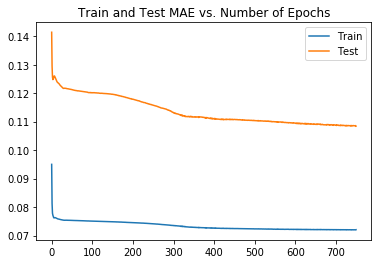

Mean absolute error of forecasted volatility using LSTM model: 0.10843537884554685


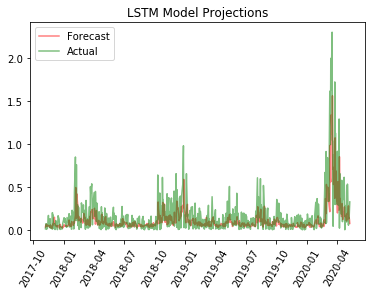

In [12]:
# LSTM RNN Model
# Implement series_to_supervised() to get lagged datatset then define train/test set
lstm_df = series_to_supervised(spy_raw_data[['adj_close_1vol','open_high_log']],1,1)
lstm_df.drop(lstm_df.columns[[3]],axis=1,inplace=True)
lstm_values = lstm_df.values
n_train = int(round(len(lstm_values)/2))
train = lstm_values[:n_train,:]
test = lstm_values[n_train:,:]
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# Define neural net framework
lstm_model = Sequential()
lstm_model.add(LSTM(50,input_shape=(train_X.shape[1],train_X.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae',optimizer='adam')
history = lstm_model.fit(train_X, train_y, epochs=750, batch_size=72, validation_data=(test_X,test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Train and Test MAE vs. Number of Epochs')
plt.legend()
plt.show()

# Make predictions and calculate MAE
yhat = lstm_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_y = test_y.reshape((len(test_y), 1))
print("Mean absolute error of forecasted volatility using LSTM model: {}".format(mean_absolute_error(yhat,test_y)))

# Transform back into DataFrames so plots display time on y-axis
test_y_df = pd.DataFrame(test_y, index = spy_raw_data[len(test)+1:].index)
yhat_df = pd.DataFrame(yhat, index = spy_raw_data[len(test)+1:].index)

# Plot Forecasted volatility vs. Realized volatility
plt.plot(yhat_df, color='red', label='Forecast', alpha=0.5)
plt.plot(test_y_df, color='green', label='Actual', alpha=0.5)
plt.xticks(rotation=60)
plt.legend()
plt.title("LSTM Model Projections")
plt.show()

In [13]:
# RANDOM FOREST REGRESSION MODELS
from sklearn.ensemble import RandomForestRegressor

# Set up 5 day lag DF of realized vol and high/low vol for supervised learning problems
lag_5_df = series_to_supervised(spy_raw_data[['adj_close_1vol','open_high_log']],5,1)
lag_5_df.drop(lag_5_df.columns[[-1]],axis=1,inplace=True)
lag_5_values = lag_5_df.values
n_train = int(round(len(lag_5_values)/2))
train_5 = lag_5_values[:n_train,:]
test_5 = lag_5_values[n_train:,:]
train_lag5_X, train_lag5_y = train_5[:,:-1], train_5[:,-1]
test_lag5_X, test_lag5_y = test_5[:,:-1], test_5[:,-1]

# Set up 10 day lag DF of realized vol and high/low vol for supervised learning problems
lag_10_df = series_to_supervised(spy_raw_data[['adj_close_1vol','open_high_log']],10,1)
lag_10_df.drop(lag_10_df.columns[[-1]],axis=1,inplace=True)
lag_10_values = lag_10_df.values
n_train = int(round(len(lag_10_values)/2))
train_10 = lag_10_values[:n_train,:]
test_10 = lag_10_values[n_train:,:]
train_lag10_X, train_lag10_y = train_10[:,:-1], train_10[:,-1]
test_lag10_X, test_lag10_y = test_10[:,:-1], test_10[:,-1]

# Set up 21 day lag DF of realized vol and high/low vol for supervised learning problems
lag_21_df = series_to_supervised(spy_raw_data[['adj_close_1vol','open_high_log']],21,1)
lag_21_df.drop(lag_21_df.columns[[-1]],axis=1,inplace=True)
lag_21_values = lag_21_df.values
n_train = int(round(len(lag_21_values)/2))
train_21 = lag_21_values[:n_train,:]
test_21 = lag_21_values[n_train:,:]
train_lag21_X, train_lag21_y = train_21[:,:-1], train_21[:,-1]
test_lag21_X, test_lag21_y = test_21[:,:-1], test_21[:,-1]

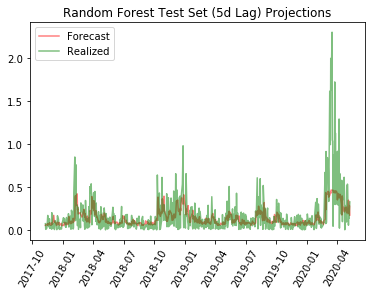

Mean Absolute Error for Random Forest Regressor (5d lag): 0.1103


In [14]:
# Define RF model w/ 5d lag and plot forecast vs. realized volatility
rf_lag5 = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=4, min_samples_split=3,
                                bootstrap=True,random_state=42)
rf_lag5.fit(train_lag5_X, train_lag5_y)
y_rf_lag5_pred = rf_lag5.predict(test_lag5_X)
y_rf_lag5_pred_df = pd.DataFrame(y_rf_lag5_pred, index = spy_raw_data[len(test_5)+5:].index)
test_lag5_y_df = pd.DataFrame(test_lag5_y, index = spy_raw_data[len(test_5)+5:].index)
plt.plot(y_rf_lag5_pred_df, color='red', label='Forecast', alpha=0.5)
plt.plot(test_lag5_y_df, color='green', label='Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Random Forest Test Set (5d Lag) Projections')
plt.legend()
plt.show()
print('Mean Absolute Error for Random Forest Regressor (5d lag): %.4f'%mean_absolute_error(test_lag5_y, y_rf_lag5_pred))

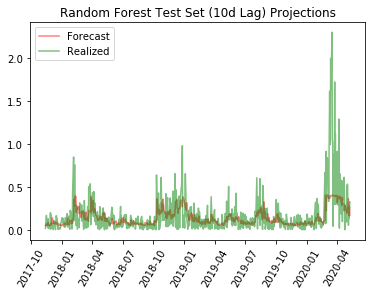

Mean Absolute Error for Random Forest Regressor (10d lag): 0.1102


In [15]:
# Define RF model w/ 10d lag and plot forecast vs. realized volatility
rf_lag10 = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=4, min_samples_split=3,
                                bootstrap=True,random_state=42)
rf_lag10.fit(train_lag10_X, train_lag10_y)
y_rf_lag10_pred = rf_lag10.predict(test_lag10_X)
y_rf_lag10_pred_df = pd.DataFrame(y_rf_lag10_pred, index = spy_raw_data[len(test_10)+9:].index)
test_lag10_y_df = pd.DataFrame(test_lag10_y, index = spy_raw_data[len(test_10)+9:].index)
plt.plot(y_rf_lag10_pred_df, color='red', label='Forecast', alpha=0.5)
plt.plot(test_lag10_y_df, color='green', label='Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Random Forest Test Set (10d Lag) Projections')
plt.legend()
plt.show()
print('Mean Absolute Error for Random Forest Regressor (10d lag): %.4f'%mean_absolute_error(test_lag10_y, y_rf_lag10_pred))

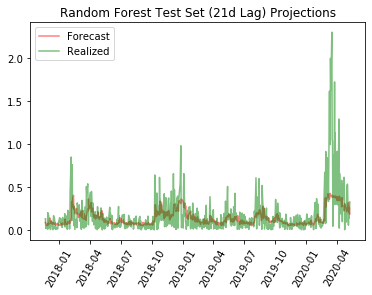

Mean Absolute Error for Random Forest Regressor (21d lag): 0.1110


In [16]:
# Define RF model w/ 21d lag and plot forecast vs. realized volatility
rf_lag21 = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=4, min_samples_split=3,
                                bootstrap=True,random_state=42)
rf_lag21.fit(train_lag21_X, train_lag21_y)
y_rf_lag21_pred = rf_lag21.predict(test_lag21_X)
y_rf_lag21_pred_df = pd.DataFrame(y_rf_lag21_pred, index = spy_raw_data[len(test_21)+21:].index)
test_lag21_y_df = pd.DataFrame(test_lag21_y, index = spy_raw_data[len(test_21)+21:].index)
plt.plot(y_rf_lag21_pred_df, color='red', label='Forecast', alpha=0.5)
plt.plot(test_lag21_y_df, color='green', label='Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Random Forest Test Set (21d Lag) Projections')
plt.legend()
plt.show()
print('Mean Absolute Error for Random Forest Regressor (21d lag): %.4f'%mean_absolute_error(test_lag21_y, y_rf_lag21_pred))


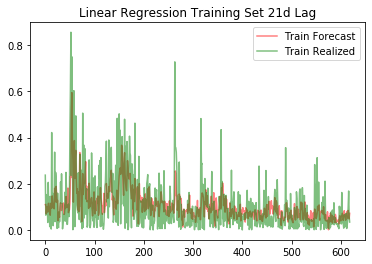

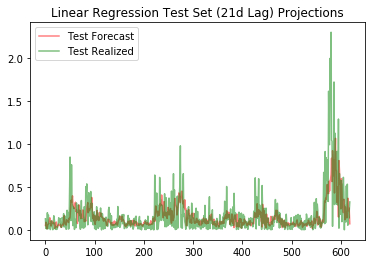

Training set Mean Absolute Error for Linear Regression: 0.0693
Test set Mean Absolute Error for Linear Regression: 0.1129
Time to train = 0.01


In [17]:
# LINEAR REGRESSION MODELS
from sklearn.linear_model import LinearRegression
import time

# Define and implement 21d lag linear regression model
lr_model_21 = LinearRegression()
lr_model_21.fit(train_lag21_X,train_lag21_y)
t0 = time.time()
lr_y_fit_21 = lr_model_21.predict(train_lag21_X)
lr_y_pred_21 = lr_model_21.predict(test_lag21_X)
tF = time.time()

# Plot forecast vs. realized volatility first for training set, then for test set
plt.plot(lr_y_fit_21, color ='red', label='Train Forecast', alpha=0.5)
plt.plot(train_lag21_y, color = 'green', label='Train Realized', alpha=0.5)
plt.title('Linear Regression Training Set 21d Lag')
plt.legend()
plt.show()
plt.plot(lr_y_pred_21, color='red', label='Test Forecast', alpha=0.5)
plt.plot(test_lag21_y, color='green', label='Test Realized', alpha=0.5)
plt.title('Linear Regression Test Set (21d Lag) Projections')
plt.legend()
plt.show()
print('Training set Mean Absolute Error for Linear Regression: %.4f'%mean_absolute_error(train_lag21_y, lr_y_fit_21))
print('Test set Mean Absolute Error for Linear Regression: %.4f'%mean_absolute_error(test_lag21_y, lr_y_pred_21))
print('Time to train = %.2f' % (tF-t0))

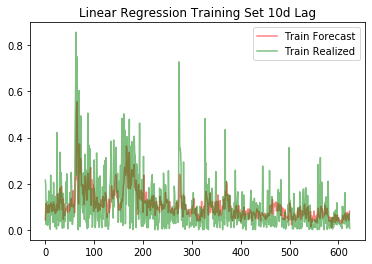

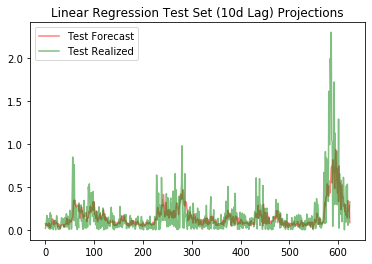

Training set Mean Absolute Error for Linear Regression: 0.0710
Test set Mean Absolute Error for Linear Regression: 0.1095
Time to train = 0.00


In [18]:
# Define and implement 10d lag linear regression model
lr_model_10 = LinearRegression()
lr_model_10.fit(train_lag10_X,train_lag10_y)
t0 = time.time()
lr_y_fit_10 = lr_model_10.predict(train_lag10_X)
lr_y_pred_10 = lr_model_10.predict(test_lag10_X)
tF = time.time()

# Plot forecast vs. realized volatility first for training set, then for test set
plt.plot(lr_y_fit_10, color ='red', label='Train Forecast', alpha=0.5)
plt.plot(train_lag10_y, color = 'green', label='Train Realized', alpha=0.5)
plt.title('Linear Regression Training Set 10d Lag')
plt.legend()
plt.show()
plt.plot(lr_y_pred_10, color='red', label='Test Forecast', alpha=0.5)
plt.plot(test_lag10_y, color='green', label='Test Realized', alpha=0.5)
plt.title('Linear Regression Test Set (10d Lag) Projections')
plt.legend()
plt.show()
print('Training set Mean Absolute Error for Linear Regression: %.4f'%mean_absolute_error(train_lag10_y, lr_y_fit_10))
print('Test set Mean Absolute Error for Linear Regression: %.4f'%mean_absolute_error(test_lag10_y, lr_y_pred_10))
print('Time to train = %.2f' % (tF-t0))

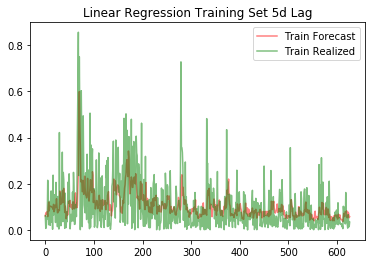

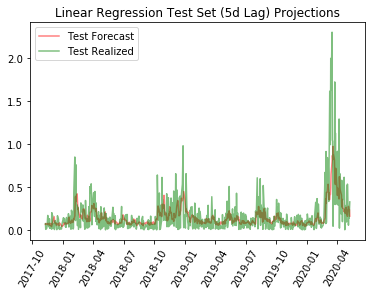

Training set Mean Absolute Error for Linear Regression: 0.0731
Test set Mean Absolute Error for Linear Regression: 0.1072
Time to train = 0.00


In [19]:
# Define and implement 5d lag linear regression model
lr_model_5 = LinearRegression()
lr_model_5.fit(train_lag5_X,train_lag5_y)
t0 = time.time()
lr_y_fit_5 = lr_model_5.predict(train_lag5_X)
lr_y_pred_5 = lr_model_5.predict(test_lag5_X)
tF = time.time()

# Plot forecast vs. realized volatility first for training set, then for test set
plt.plot(lr_y_fit_5, color ='red', label='Train Forecast', alpha=0.5)
plt.plot(train_lag5_y, color = 'green', label='Train Realized', alpha=0.5)
plt.title('Linear Regression Training Set 5d Lag')
plt.legend()
plt.show()
lr_y_pred_5_df = pd.DataFrame(lr_y_pred_5, index = spy_raw_data[len(test_5)+5:].index)
plt.plot(lr_y_pred_5_df, color='red', label='Test Forecast', alpha=0.5)
plt.plot(test_lag5_y_df, color='green', label='Test Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Linear Regression Test Set (5d Lag) Projections')
plt.legend()
plt.show()
print('Training set Mean Absolute Error for Linear Regression: %.4f'%mean_absolute_error(train_lag5_y, lr_y_fit_5))
print('Test set Mean Absolute Error for Linear Regression: %.4f'%mean_absolute_error(test_lag5_y, lr_y_pred_5))
print('Time to train = %.2f' % (tF-t0))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.65      1.44556e+07        3          0.12055              N/A     11.21s
   1     5.65      1.49647e+06        5         0.125746              N/A     23.78s
   2     3.38           695.67        7         0.122349              N/A     25.80s
   3     3.55          4684.28        7         0.119728              N/A     21.15s
   4     3.47          121.225       13         0.111302              N/A     17.31s
   5     3.78          3.11834        9         0.111378              N/A     14.39s
   6     4.48          1765.01        9         0.108835              N/A     10.97s
   7     5.31          1.35551        9         0.108835              N/A      8.31s
   8     6.20          7.13773       13         0.107635              N/A  

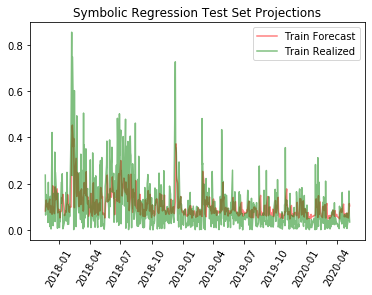

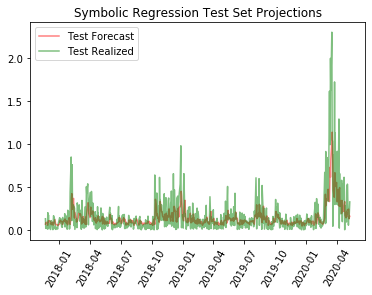

Training set Mean Absolute Error for Symbolic Regression: 0.0770
Test set Mean Absolute Error for Symbolic Regression: 0.1095
Time to train = 34.63
add(sub(X39, -0.039), add(X39, mul(add(X40, X38), 0.235)))


In [20]:
# SYMBOLIC REGRESSION MODELS
from gplearn.genetic import SymbolicRegressor

# Define Symoblic Regression model and fit, then generate predictions
if 'model' in locals(): del model
model = SymbolicRegressor(population_size=3000,tournament_size=5,generations=10,
                          stopping_criteria=0.1, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15, p_hoist_mutation=0.05,
                          p_point_mutation=0.1,verbose=1,random_state=42, n_jobs=-1)
t0 = time.time()
model.fit(train_lag21_X, train_lag21_y)
tF = time.time()
sr_y_fit = model.predict(train_lag21_X).reshape(-1,1)
sr_y_pred = model.predict(test_lag21_X).reshape(-1,1)

# Plot predicted vs. realized volatility for training and test sets
sr_y_fit_df = pd.DataFrame(sr_y_fit, index = spy_raw_data[len(train_21)+21:].index)
train_lag21_y_df = pd.DataFrame(train_lag21_y, index = spy_raw_data[len(train_21)+21:].index)
plt.plot(sr_y_fit_df, color ='red', label='Train Forecast', alpha=0.5)
plt.plot(train_lag21_y_df, color = 'green', label='Train Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Symbolic Regression Test Set Projections')
plt.legend()
plt.show()
sr_y_pred_df = pd.DataFrame(sr_y_pred, index = spy_raw_data[len(test_21)+21:].index)
plt.plot(sr_y_pred_df, color ='red', label='Test Forecast', alpha=0.5)
plt.plot(test_lag21_y_df, color = 'green', label='Test Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Symbolic Regression Test Set Projections')
plt.legend()
plt.show()
print('Training set Mean Absolute Error for Symbolic Regression: %.4f'%mean_absolute_error(train_lag21_y, sr_y_fit))
print('Test set Mean Absolute Error for Symbolic Regression: %.4f'%mean_absolute_error(test_lag21_y, sr_y_pred))
print('Time to train = %.2f' % (tF-t0))
print(model._program)

In [21]:
# ELM MODEL
# Define Network class for use in Extreme Learning Machine model
import copy as cp
class Network(object):
    def __init__(self, input_dim, hidden_dim=10, output_dim=1, random_state=None):
        '''
        Neural Network object 
        '''
        self.N = input_dim
        self.M = hidden_dim
        self.O = output_dim
        
        self.W1 = np.matrix(np.random.rand(self.N, self.M))
        self.W2 = np.matrix(np.random.rand(self.M, self.O))
        
        self.U = 0
        self.V = 0
        self.S = 0
        self.H = 0
        self.alpha = 0 # for regularization
        
        self.random_state = random_state
        
    # Helper function
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-0.1 * x)) - 0.5
    
    def predict(self, x):
        '''
        Forward pass to calculate the ouput
        '''
        x = np.matrix(x)
        y = self.sigmoid(x @ self.W1) @ self.W2
        return y
    
    def train(self, x, y):
        '''
        Compute W2 that lead to minimal LS
        '''
        X = np.matrix(x)
        Y = np.matrix(y)
        self.H = np.matrix(self.sigmoid(X @ self.W1))
        H = cp.deepcopy(self.H)
        
        self.svd(H)
        iH = np.matrix(self.V) @ np.matrix(np.diag(self.S)).I @ np.matrix(self.U).T

        self.W2 = iH * Y
        print('W2 values updated..')
        return H @ self.W2 - Y
    
    def svd(self, h):
        '''
        Compute the Singular Value Decomposition of a matrix H
        '''
        H = np.matrix(h)
        self.U, self.S, Vt = np.linalg.svd(H, full_matrices=False)
        self.V = np.matrix(Vt).T
        print('SVD computed.. calculating Pseudoinverse..')
        return np.matrix(self.U), np.matrix(self.S), np.matrix(self.V)

SVD computed.. calculating Pseudoinverse..
W2 values updated..


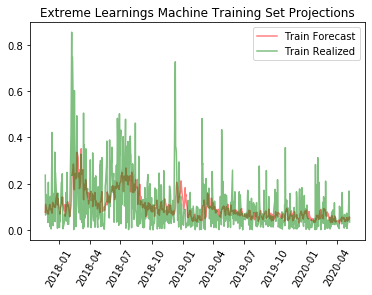

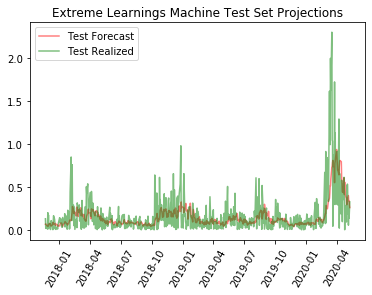

Training set Mean Absolute Error for Neural Network: 0.0746
Test set Mean Absolute Error for Neural Network: 0.1148
Time to train = 0.00


In [22]:
# Define ELM model, fit and then generate predictions
in_dim = train_lag21_X.shape[1]
NN = Network(input_dim=in_dim, hidden_dim=5, output_dim=1, random_state=42)
t0 = time.time()
eml_residuals = NN.train(x=train_lag21_X, y=train_lag21_y.reshape(-1,1))
tF = time.time()
fit = NN.predict(train_lag21_X)
predictions = NN.predict(test_lag21_X)
eml_fit = cp.deepcopy(fit)
eml_pred = cp.deepcopy(predictions)

# Plot forecast vs. realized volatility for training and test sets
eml_fit_df = pd.DataFrame(eml_fit, index = spy_raw_data[len(train_21)+21:].index)
plt.plot(eml_fit_df, color ='red', label='Train Forecast', alpha=0.5)
plt.plot(train_lag21_y_df, color = 'green', label='Train Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Extreme Learnings Machine Training Set Projections')
plt.legend()
plt.show()
eml_pred_df = pd.DataFrame(eml_pred, index = spy_raw_data[len(test_21)+21:].index)
plt.plot(eml_pred_df, color='red', label='Test Forecast', alpha=0.5)
plt.plot(test_lag21_y_df, color='green', label='Test Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('Extreme Learnings Machine Test Set Projections')
plt.legend()
plt.show()
print('Training set Mean Absolute Error for Neural Network: %.4f'%mean_absolute_error(train_lag21_y, eml_fit))
print('Test set Mean Absolute Error for Neural Network: %.4f'%mean_absolute_error(test_lag21_y, eml_pred))
print('Time to train = %.2f' % (tF-t0))

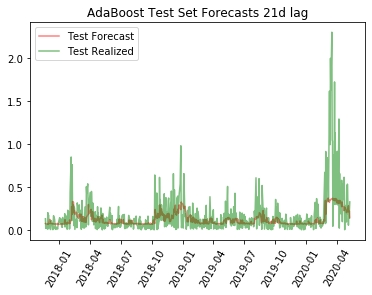

Mean Absolute Error for AdaBoost Regressor (21d lag): 0.1112


In [23]:
# ADABOOST REGRESSION MODEL
# Fit model w/ parameters, generate predictions and plot forecast vs. realized volatility for test set
from sklearn.ensemble import AdaBoostRegressor
ada_lag21 = AdaBoostRegressor(n_estimators=500,learning_rate=0.0001, random_state=42)
ada_lag21.fit(train_lag21_X,train_lag21_y)
y_ada_lag21_pred = ada_lag21.predict(test_lag21_X)
y_ada_lag21_pred_df = pd.DataFrame(y_ada_lag21_pred, index = spy_raw_data[len(test_21)+21:].index)
plt.plot(y_ada_lag21_pred_df, color ='red', label='Test Forecast', alpha=0.5)
plt.plot(test_lag21_y_df, color = 'green', label='Test Realized', alpha=0.5)
plt.xticks(rotation=60)
plt.title('AdaBoost Test Set Forecasts 21d lag')
plt.legend()
plt.show()
print('Mean Absolute Error for AdaBoost Regressor (21d lag): %.4f'%mean_absolute_error(test_lag21_y, y_ada_lag21_pred))

In [24]:
# Print MAE for all models, to be used in summary table
print("Mean absolute error of forecasted volatility for fixed rolling window GARCH model: {}".format(arch_mae))
print("Mean absolute error of forecasted volatility using null model: {}".format(null_mae))
print("Mean absolute error of forecasted volatility for expanding window GARCH model: {}".format(garch_exp_mae))
print("Mean absolute error of forecasted volatility for expanding window EGARCH model: {}".format(egarch_exp_mae))
print("Mean absolute error of forecasted volatility for expanding window GJR GARCH model: {}".format(gjrgarch_exp_mae))
print("Mean absolute error of forecasted volatility using LSTM model: {}".format(mean_absolute_error(yhat,test_y)))
print('Mean Absolute Error for Random Forest Regressor (5d lag): %.4f'%mean_absolute_error(test_lag5_y, y_rf_lag5_pred))
print('Mean Absolute Error for Random Forest Regressor (10d lag): %.4f'%mean_absolute_error(test_lag10_y, y_rf_lag10_pred))
print('Mean Absolute Error for Random Forest Regressor (21d lag): %.4f'%mean_absolute_error(test_lag21_y, y_rf_lag21_pred))
print('Mean Absolute Error for Linear Regression model: %.4f'%mean_absolute_error(test_lag21_y, lr_y_pred_21))
print('Mean Absolute Error for Symbolic Regression: %.4f'%mean_absolute_error(test_lag21_y, sr_y_pred))
print('Mean Absolute Error for Neural Network: %.4f'%mean_absolute_error(test_lag21_y, eml_pred))
print('Mean Absolute Error for AdaBoost Regressor (21d lag): %.4f'%mean_absolute_error(test_lag21_y, y_ada_lag21_pred))

Mean absolute error of forecasted volatility for fixed rolling window GARCH model: 0.08451423218715327
Mean absolute error of forecasted volatility using null model: 0.12014163249653342
Mean absolute error of forecasted volatility for expanding window GARCH model: 0.08161670916931622
Mean absolute error of forecasted volatility for expanding window EGARCH model: 0.07981916554958202
Mean absolute error of forecasted volatility for expanding window GJR GARCH model: 0.08016636447312712
Mean absolute error of forecasted volatility using LSTM model: 0.10843537884554685
Mean Absolute Error for Random Forest Regressor (5d lag): 0.1103
Mean Absolute Error for Random Forest Regressor (10d lag): 0.1102
Mean Absolute Error for Random Forest Regressor (21d lag): 0.1110
Mean Absolute Error for Linear Regression model: 0.1129
Mean Absolute Error for Symbolic Regression: 0.1095
Mean Absolute Error for Neural Network: 0.1148
Mean Absolute Error for AdaBoost Regressor (21d lag): 0.1112


In [25]:
# The following code was used to tune the hyperparameters used in the random forest modeling section
from sklearn.model_selection import GridSearchCV
train_rf_X, train_rf_y = train[:,:-1], train[:,-1]
test_rf_X, test_rf_y = test[:,:-1], test[:,-1]
# GridSearchCV portion of hyperparameter tuning:
n_estimators=[50, 100, 200, 300]
max_depth = [5, 10, 20, 30]
min_samples_split = [3, 4, 5, 6, 7]
min_samples_leaf = [1,2,3,4]
bootstrap=[True]
random_grid = {'n_estimators': n_estimators,'max_depth':max_depth,
                'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,
                'bootstrap':bootstrap}
rf = RandomForestRegressor(random_state=42)
rf_regressor_gs = GridSearchCV(rf, param_grid=random_grid)
rf_regressor_gs.fit(train_rf_X,train_rf_y)
y_rf_gs_pred = rf_regressor_gs.predict(test_rf_X)
print('Mean Absolute Error for Random Forest Regressor: %.2f'%mean_absolute_error(test_rf_y, y_rf_gs_pred))
print("Tuned Random Forest Parameters: {}".format(rf_regressor_gs.best_params_))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Absolute Error for Random Forest Regressor: 0.11
Tuned Random Forest Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 200}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
